# Medical Insurance Costs Prediction

## Introduction
In this notebook, we will explore and analyze a medical insurance dataset and build machine learning models to predict medical insurance costs for individuals. The dataset contains information about various factors that could influence insurance costs, such as age, BMI, smoking status, gender, number of children, and region of residence.

## Import Libraries
Let's start by importing the necessary libraries for data analysis and modeling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
import scikitplot as skplt
from matplotlib.pylab import rcParams

## Dataset Analysis
### Loading Data
Let's start by loading the medical insurance dataset.

In [2]:
insurance_df = pd.read_csv('insurance.csv')

### Data Overview
Let's take a look at the first few rows of the dataset to get an overview.

In [3]:
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
insurance_df.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


### Data Types and Missing Values
Next, let's check the data types and look for any missing values.

In [5]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


The dataset does not contain any missing values.

### Data Preprocessing
We'll transform categorical variables into numeric using Label Encoding.

In [6]:
le = LabelEncoder()
insurance_df['sex'] = le.fit_transform(insurance_df['sex'])
insurance_df['smoker'] = le.fit_transform(insurance_df['smoker'])
insurance_df['region'] = le.fit_transform(insurance_df['region'])

### Descriptive Statistics
Let's explore the descriptive statistics of the dataset.

In [7]:
insurance_df.describe()

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,1.515695,13270.422265
std,14.049960,0.500160,6.098187,1.205493,0.403694,1.104885,12110.011237
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.296250,0.000000,0.000000,1.000000,4740.287150
50%,39.000000,1.000000,30.400000,1.000000,0.000000,2.000000,9382.033000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,2.000000,16639.912515
max,64.000000,1.000000,53.130000,5.000000,1.000000,3.000000,63770.428010


### Insurance Charges Analysis
We'll visualize the distribution of insurance charges using a histogram.

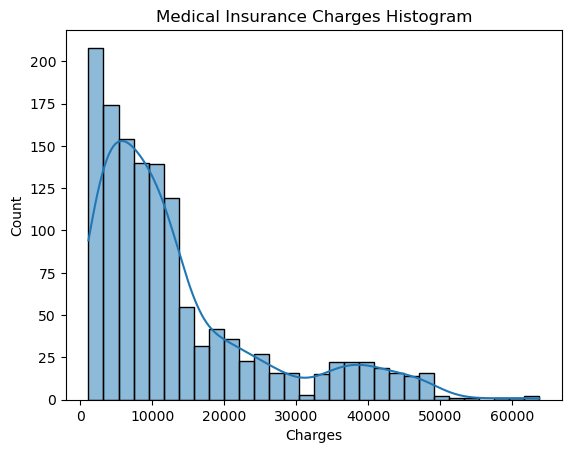

In [8]:
sns.histplot(insurance_df['charges'], kde=True)
plt.title("Medical Insurance Charges Histogram")
plt.xlabel("Charges")
plt.show()

### Correlation Analysis
Let's analyze the correlation between variables.

In [9]:
correlation = insurance_df.corr()
correlation['charges'].sort_values(ascending=False)

charges     1.000000
smoker      0.787251
age         0.299008
bmi         0.198341
children    0.067998
sex         0.057292
region     -0.006208
Name: charges, dtype: float64

We'll also visualize the correlation matrix.

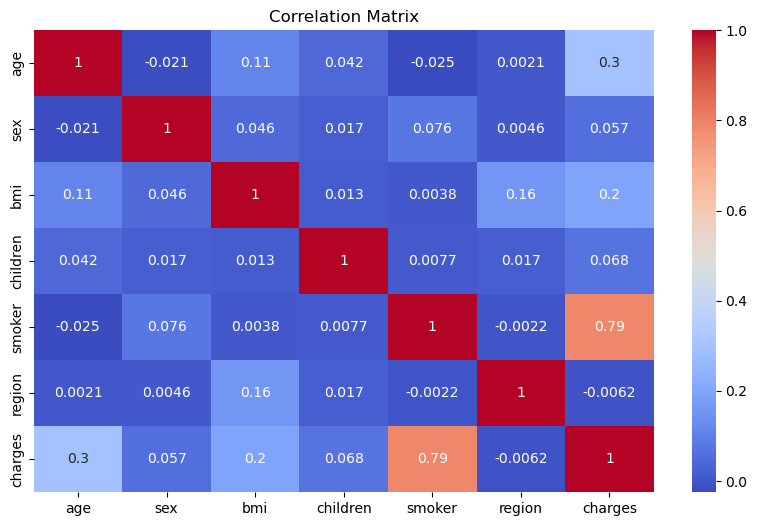

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

We can see the correlation values and visualize them as a bar plot.

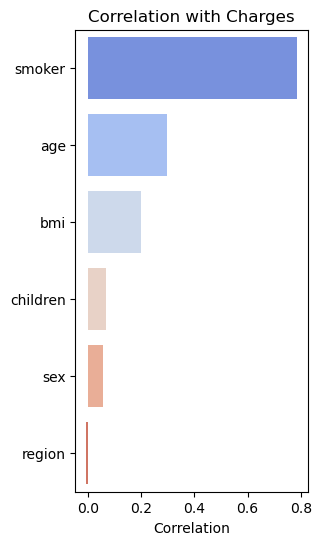

In [11]:
correlation = correlation.sort_values('charges', ascending=False)

plt.figure(figsize=(3, 6))
sns.barplot(x=correlation['charges'].drop('charges').values, y=correlation['charges'].drop('charges').index, palette='coolwarm')
plt.title('Correlation with Charges')
plt.xlabel('Correlation')
plt.ylabel('')
plt.show()

### Age Analysis
Let's visualize the distribution of ages using a histogram.

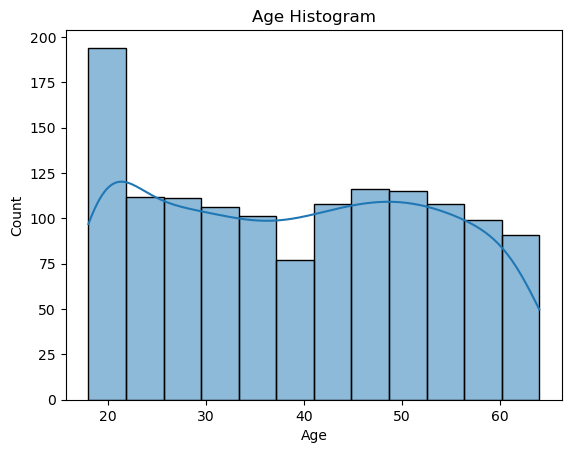

In [12]:
sns.histplot(insurance_df['age'], kde=True)
plt.title("Age Histogram")
plt.xlabel("Age")
plt.show()

Based on the histogram, we can conclude that the study group is the working age population (18 - 64 years).

### Analysis of Factors Affecting Charges
We'll perform an analysis of the relationship between gender, region, smoking, BMI, and the number of children with insurance charges.

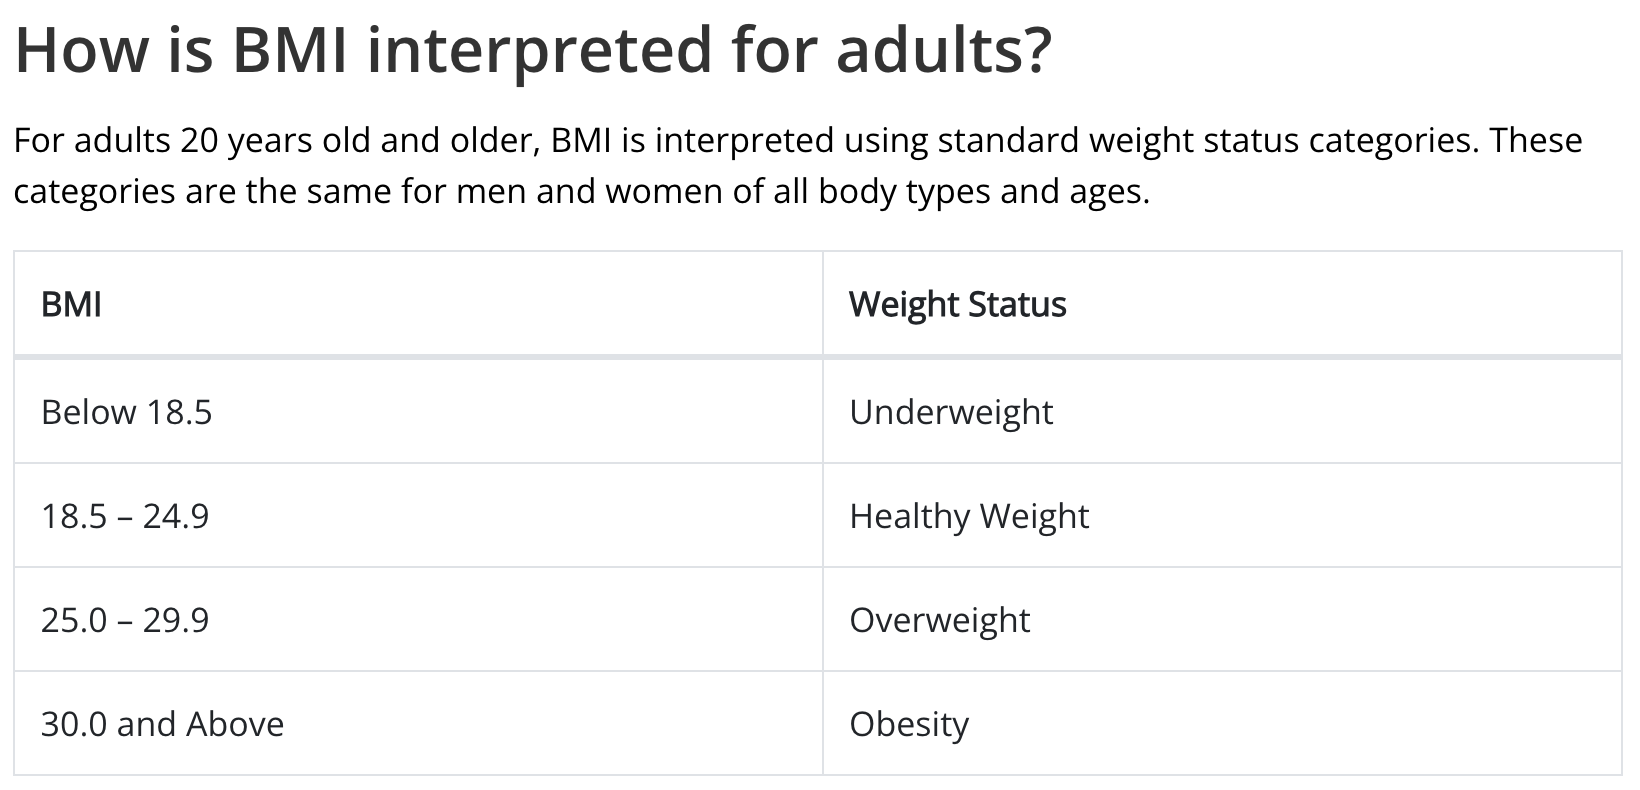

The database includes the working age population, so the above breakdown is applied to all respondents.

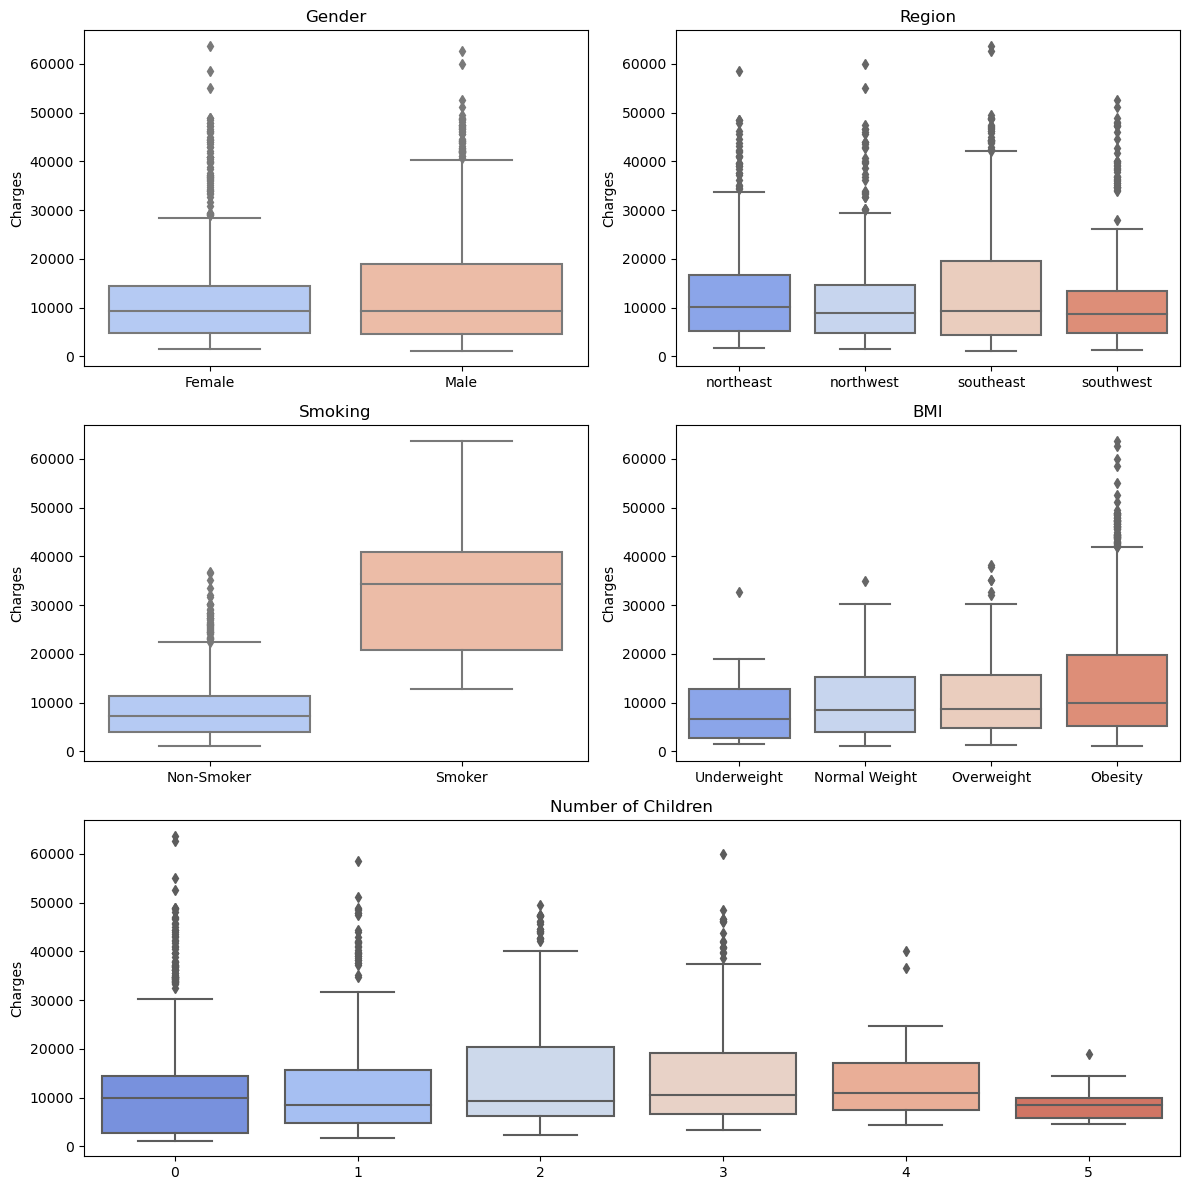

In [13]:
analysis_df = insurance_df.copy()

analysis_df['bmi_category'] = pd.cut(analysis_df['bmi'], bins=[0, 18.5, 24.9, 29.9, float('inf')],
                                     labels=['Underweight', 'Normal Weight', 'Overweight', 'Obesity'])

plt.figure(figsize=(12, 12))

plt.subplot(3, 2, 1)
sns.boxplot(x='sex', y='charges', data=analysis_df, palette='coolwarm')
plt.title("Gender")
plt.xlabel("")
plt.ylabel("Charges")
plt.xticks([0, 1], ['Female', 'Male'])

plt.subplot(3, 2, 2)
sns.boxplot(x='region', y='charges', data=analysis_df, palette='coolwarm')
plt.title("Region")
plt.xlabel("")
plt.ylabel("Charges")
plt.xticks([0, 1, 2, 3], ['northeast', 'northwest', 'southeast', 'southwest'])

plt.subplot(3, 2, 3)
sns.boxplot(x='smoker', y='charges', data=analysis_df, palette='coolwarm')
plt.title("Smoking")
plt.xlabel("")
plt.ylabel("Charges")
plt.xticks([0, 1], ['Non-Smoker', 'Smoker'])

plt.subplot(3, 2, 4)
sns.boxplot(x='bmi_category', y='charges', data=analysis_df, palette='coolwarm')
plt.title("BMI")
plt.xlabel("")
plt.ylabel("Charges")

plt.subplot2grid((3, 2), (2, 0), colspan=2)
sns.boxplot(x='children', y='charges', data=analysis_df, palette='coolwarm')
plt.title("Number of Children")
plt.xlabel("")
plt.ylabel("Charges")

plt.tight_layout()
plt.show()

### Pairplot with Smoking Separation
We'll create a pairplot to analyze relationships between variables, with a separation based on smoking status.

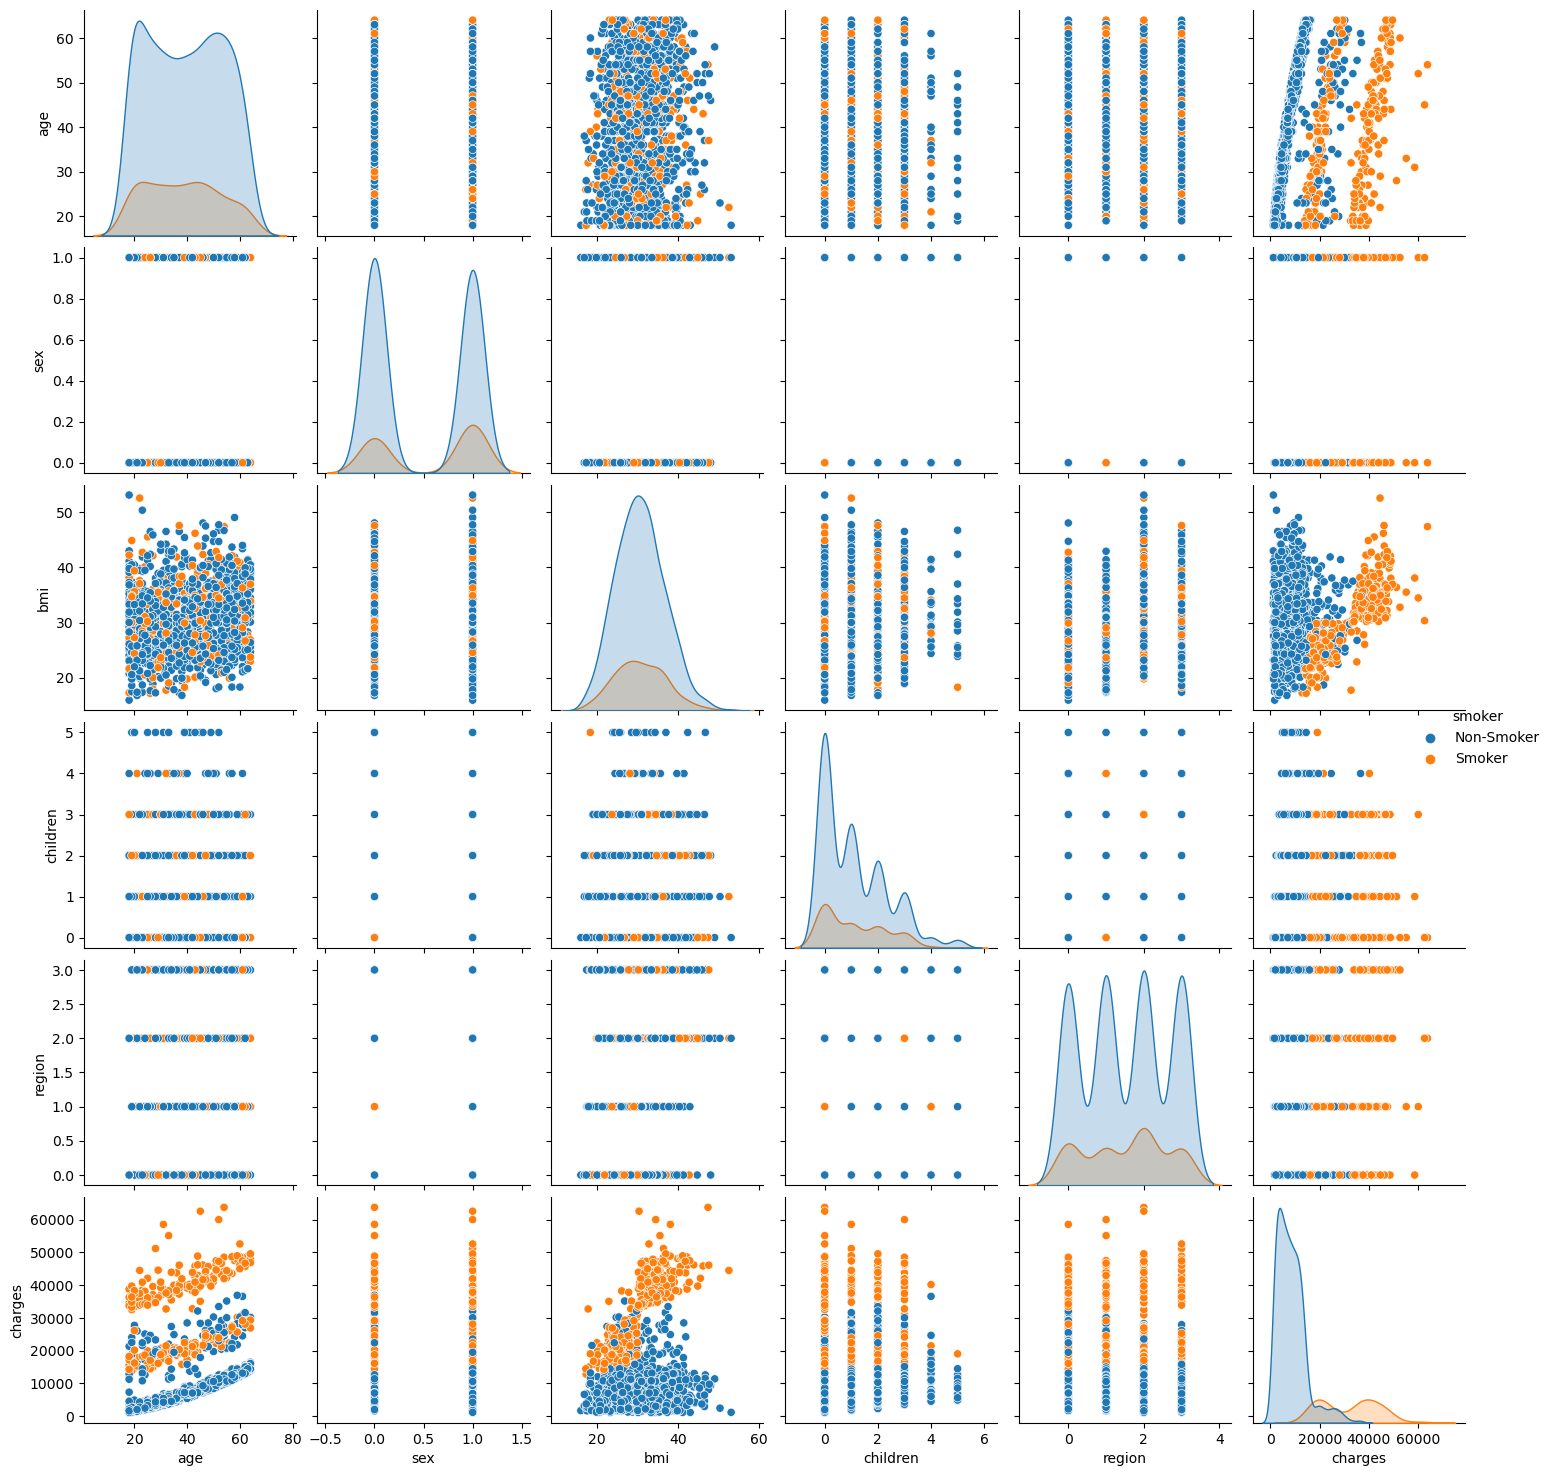

In [14]:
pplot = sns.pairplot(analysis_df, hue="smoker")
legend_labels = ['Non-Smoker', 'Smoker']
for t, l in zip(pplot._legend.texts, legend_labels):
    t.set_text(l)
plt.show()

### Comparison of Correlation for Smokers and Non-Smokers
We'll analyze the correlation separately for smokers and non-smokers.

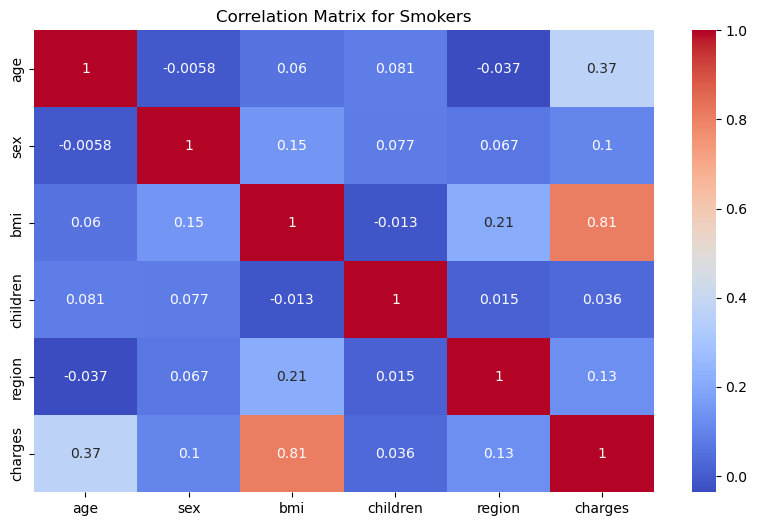

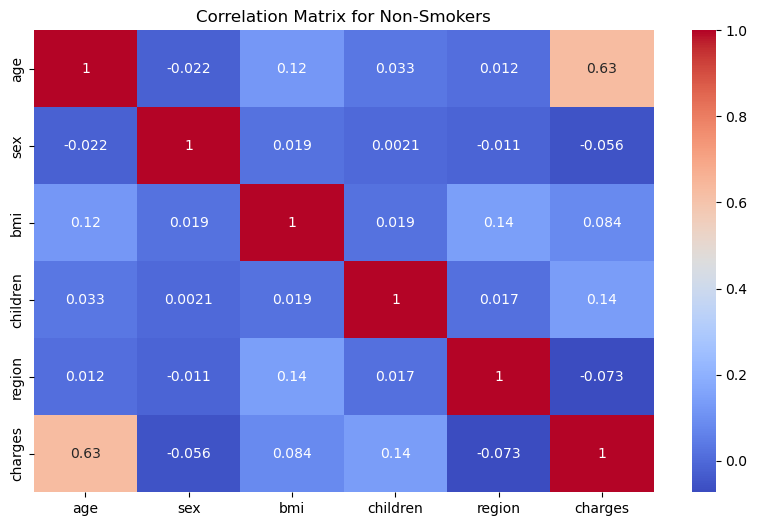

In [15]:
insurance_df_s = insurance_df[(analysis_df['smoker'] == 1)]
insurance_df_ns = insurance_df[(analysis_df['smoker'] == 0)]

corr_matrix_s = insurance_df_s.drop(columns=['smoker']).corr()
corr_matrix_ns = insurance_df_ns.drop(columns=['smoker']).corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_s, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix for Smokers")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_ns, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix for Non-Smokers")
plt.show()

### Comparison of Correlation for Smokers and Non-Smokers - Bar Plot
We'll visualize the correlation values as bar plots for smokers and non-smokers.

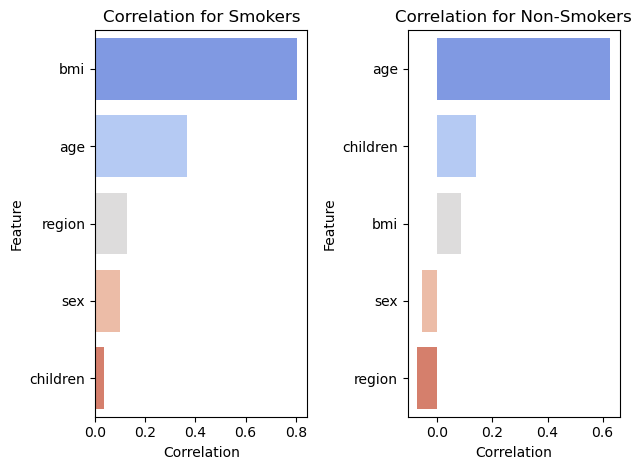

In [16]:
corr_matrix_s = corr_matrix_s.sort_values('charges', ascending=False)
corr_matrix_ns = corr_matrix_ns.sort_values('charges', ascending=False)

plt.subplot(1, 2, 1)
sns.barplot(x=corr_matrix_s['charges'].drop('charges').values, y=corr_matrix_s['charges'].drop('charges').index, palette='coolwarm')
plt.title('Correlation for Smokers')
plt.xlabel('Correlation')
plt.ylabel('Feature')

plt.subplot(1, 2, 2)
sns.barplot(x=corr_matrix_ns['charges'].drop('charges').values, y=corr_matrix_ns['charges'].drop('charges').index, palette='coolwarm')
plt.title('Correlation for Non-Smokers')
plt.xlabel('Correlation')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()

For non-smokers, we observe a negative correlation, so for visualization and estimation of the significance of the features, we convert the values to positive.

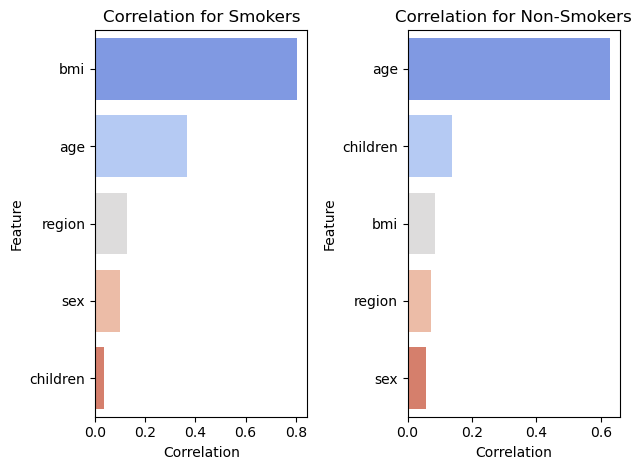

In [17]:
corr_matrix_s = corr_matrix_s.sort_values('charges', ascending=False)
corr_matrix_ns_abs = abs(corr_matrix_ns).sort_values('charges', ascending=False)

plt.subplot(1, 2, 1)
sns.barplot(x=corr_matrix_s['charges'].drop('charges').values, y=corr_matrix_s['charges'].drop('charges').index, palette='coolwarm')
plt.title('Correlation for Smokers')
plt.xlabel('Correlation')
plt.ylabel('Feature')

plt.subplot(1, 2, 2)
sns.barplot(x=corr_matrix_ns_abs['charges'].drop('charges').values, y=corr_matrix_ns_abs['charges'].drop('charges').index, palette='coolwarm')
plt.title('Correlation for Non-Smokers')
plt.xlabel('Correlation')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()

## ML - Insurance Cost Prediction Models
We'll build machine learning models to predict insurance costs using the features available in the dataset.

### Data Preparation
Let's prepare the data by splitting it into feature variables (X) and the target variable (y).

In [18]:
X = insurance_df.drop(columns=['charges'], axis=1)
y = insurance_df['charges']

### Train-Test Split
We'll split the data into training and test sets.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Validation Setup
We'll use k-fold cross-validation for model evaluation.

In [20]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

### Model Selection
We'll consider the following models for prediction:

Linear Regression
Lasso Regression
Ridge Regression
ElasticNet Regression
Decision Tree Regressor
Random Forest Regressor
XGBoost Regressor
Let's train these models and evaluate their performance.

### Model Evaluation
We'll define a function to train the model, perform k-fold cross-validation, and evaluate the root mean squared error (RMSE) and R-squared (R2) scores.

In [21]:
def run_model(model, X, y, cross_val):
    """
    Evaluate the performance of a given machine learning model using cross-validation.

    Parameters:
    - model: The machine learning model to be evaluated.
    - X: The feature matrix (input data) used for training and testing the model.
    - y: The target vector (output data) used for training and testing the model.
    - cross_val: The number of cross-validation folds or a cross-validation strategy (e.g., KFold, StratifiedKFold)
                 to use during evaluation.

    Returns:
    - results: A dictionary containing the evaluation results of the model, including:
      - 'Model': The name of the model (extracted from the model object).
      - 'RMSE': The average Root Mean Squared Error across all cross-validation folds.
      - 'R2': The average R-squared (R2) score multiplied by 100 (to represent it as a percentage)
              across all cross-validation folds.
    """
    model_name = type(model).__name__

    rmse = -cross_val_score(model, X, y, cv=cross_val, scoring='neg_root_mean_squared_error')
    r2 = cross_val_score(model, X, y, cv=cross_val, scoring='r2')
    results = {
        'Model': model_name,
        'RMSE': round(np.mean(rmse), 4),
        'R2': round(np.mean(r2) * 100, 2)
    }

    return results

Now, let's run the models and collect the results.

In [22]:
lr = LinearRegression()
lasso = Lasso(random_state=42)
ridge = Ridge(random_state=42)
enet = ElasticNet(random_state=42)
tree = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

models = [lr, lasso, ridge, enet, tree, rf, xgb_reg]
results_dict = {}

for model in models:
    results = run_model(model, X_train, y_train, kf)
    results_dict[model] = results

results_df = pd.DataFrame(results_dict.values())
results_df.columns = ['Model', 'RMSE', 'R2']
results_df

,Model,RMSE,R2
0,LinearRegression,6112.6762,73.98
1,Lasso,6112.5643,73.98
2,Ridge,6112.8442,73.98
3,ElasticNet,9451.2912,37.85
4,DecisionTreeRegressor,6560.5875,69.96
5,RandomForestRegressor,4916.0771,83.18
6,XGBRegressor,5369.6282,79.95


In [23]:
def plot_model_comparison(df):
    """
    Plot a comparison of different machine learning models based on their RMSE and R2 scores.

    Parameters:
    - df: A pandas DataFrame containing the model evaluation results, including:
          - 'Model': The name of the model.
          - 'RMSE': The Root Mean Squared Error for each model.
          - 'R2': The R-squared (R2) score for each model.

    Returns:
    - None: This function generates and displays a bar plot to compare models based on RMSE and R2 scores.
    """
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    sns.barplot(y='Model', x='RMSE', data=df.sort_values('RMSE'), palette='coolwarm')
    plt.title('Comparison of RMSE')
    plt.ylabel('')
    plt.xlabel('RMSE')
    plt.ticklabel_format(style='plain', axis='x')

    plt.subplot(1, 2, 2)
    sns.barplot(y='Model', x='R2', data=df.sort_values('R2', ascending=False), palette='coolwarm')
    plt.title('Comparison of R2 Score')
    plt.ylabel('')
    plt.xlabel('R2')

    plt.tight_layout()
    plt.show()

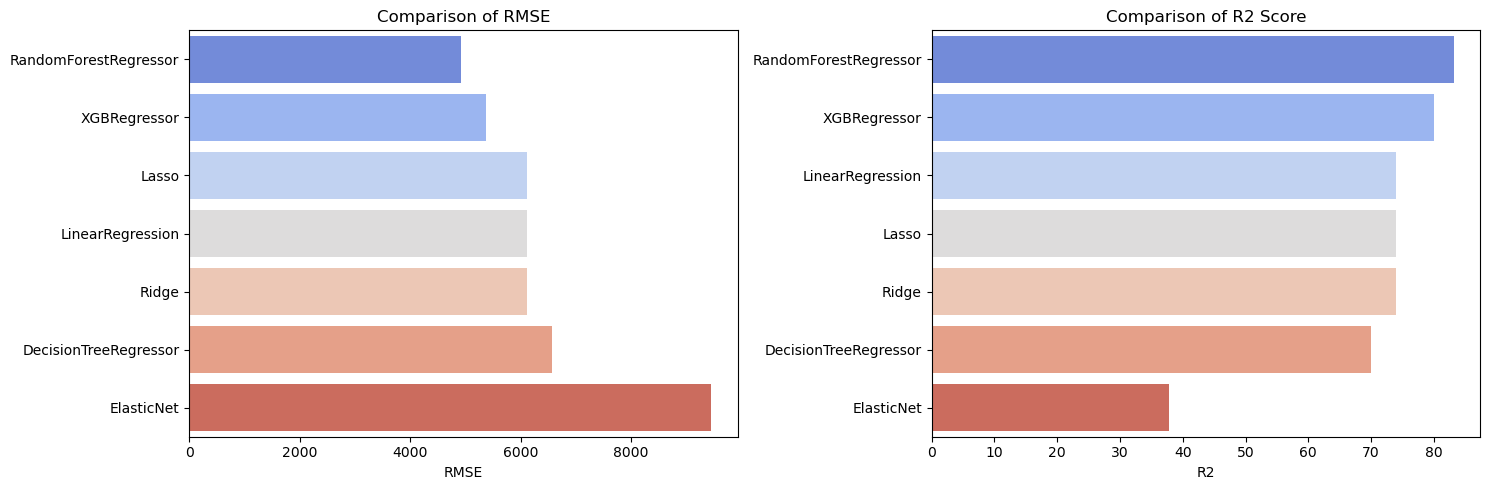

In [24]:
plot_model_comparison(results_df)

### Data Preprocessing with Polynomial Features and Standard Scaling
We'll preprocess the data by applying PolynomialFeatures and StandardScaler.

In [25]:
num_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2)),
    ('std_scaler', StandardScaler())
])

num_attribs = ['age', 'bmi', 'sex', 'smoker', 'region', 'children']

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs)
])

X_pp = full_pipeline.fit_transform(X)

X_train_pp, X_test_pp, y_train_pp, y_test_pp = train_test_split(X_pp, y, test_size=0.2, random_state=42)

### Model Evaluation with Preprocessed Data
We'll rerun the models with preprocessed data and compare the results.

In [26]:
results_dict_pp = {}

for model in models:
    results = run_model(model, X_train_pp, y_train_pp, kf)
    results_dict[model] = results

results_pp_df = pd.DataFrame(results_dict.values())
results_pp_df.columns = ['Model', 'RMSE', 'R2']
results_pp_df

/Users/jakubsutowski/anaconda3/envs/envpy/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.947e+08, tolerance: 1.202e+07
  model = cd_fast.enet_coordinate_descent(
/Users/jakubsutowski/anaconda3/envs/envpy/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.866e+08, tolerance: 1.233e+07
  model = cd_fast.enet_coordinate_descent(
/Users/jakubsutowski/anaconda3/envs/envpy/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of 

,Model,RMSE,R2
0,LinearRegression,4869.1251,83.43
1,Lasso,4862.0932,83.48
2,Ridge,4861.3720,83.49
3,ElasticNet,5831.2941,76.31
4,DecisionTreeRegressor,6557.8363,70.03
5,RandomForestRegressor,4890.7077,83.34
6,XGBRegressor,5243.6636,80.83


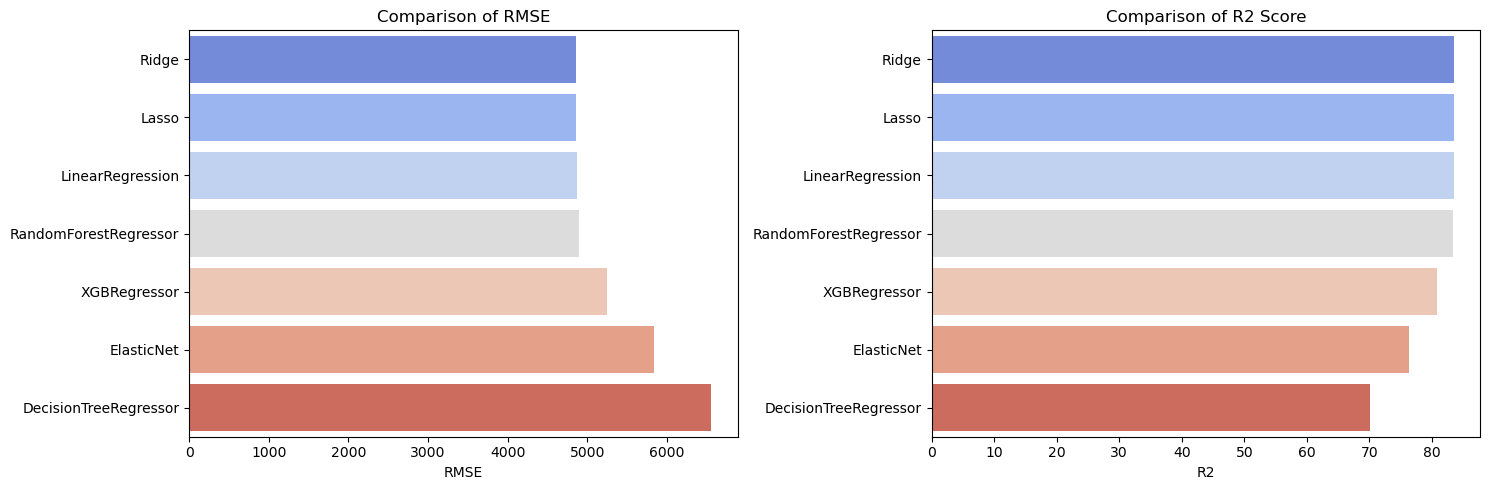

In [27]:
plot_model_comparison(results_pp_df)

### Hyperparameter Tuning
We'll perform hyperparameter tuning for selected models to improve their performance.

In [28]:
def tune_hyperparameters(model, param_grid, X_train, y_train, kf):
    """
    Tune hyperparameters of a machine learning model using GridSearchCV and evaluate the best model.

    Parameters:
    - model: The machine learning model to be tuned.
    - param_grid: A dictionary specifying the hyperparameter grid to search over.
    - X_train: The feature matrix (input data) for training the model.
    - y_train: The target vector (output data) for training the model.
    - kf: The number of cross-validation folds or a cross-validation strategy (e.g., KFold, StratifiedKFold)
          to use during hyperparameter tuning and model evaluation.

    Returns:
    - best_model: The best model obtained after hyperparameter tuning.
    - best_results: A dictionary containing the evaluation results of the best model, including:
                    - 'Model': The name of the best model.
                    - 'RMSE': The average Root Mean Squared Error across all cross-validation folds.
                    - 'R2': The average R-squared (R2) score multiplied by 100 (to represent it as a percentage)
                            across all cross-validation folds.
    """
    grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_results = run_model(best_model, X_train, y_train, kf)

    return best_model, best_results

In [29]:
param_grid_lr = {
    'fit_intercept': [True, False]
}

param_grid_lasso = {
    'fit_intercept': [True, False]
}

param_grid_ridge = {
    'alpha': [0.1, 1.0, 10.0],
    'fit_intercept': [True, False]
}

param_grid_enet = {
    'alpha': [0.1, 1.0, 10.0],
    'l1_ratio': [0.2, 0.5, 0.8],
    'fit_intercept': [True, False],
}

param_grid_tree = {
    "min_samples_split": [2, 5, 10, 20, 40],
    "max_depth": range(1, 11),
    "min_samples_leaf": range(30, 45),
    "max_leaf_nodes": range(15, 23),
}

param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": range(1, 10, 1),
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4, 6]
}

param_grid_xgb = {
    'max_depth': range(2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

lr_best_model, results_lr = tune_hyperparameters(lr, param_grid_lr, X_train_pp, y_train_pp, kf)
lasso_best_model, results_lasso = tune_hyperparameters(lasso, param_grid_lasso, X_train_pp, y_train_pp, kf)
ridge_best_model, results_ridge = tune_hyperparameters(ridge, param_grid_ridge, X_train_pp, y_train_pp, kf)
enet_best_model, results_enet = tune_hyperparameters(enet, param_grid_enet, X_train_pp, y_train_pp, kf)
tree_best_model, results_tree = tune_hyperparameters(tree, param_grid_tree, X_train_pp, y_train_pp, kf)
rf_best_model, results_rf = tune_hyperparameters(rf, param_grid_rf, X_train, y_train, kf)
xgb_best_model, results_xgb = tune_hyperparameters(xgb_reg, param_grid_xgb, X_train, y_train, kf)

results_grid_df = pd.DataFrame([results_lr, results_lasso, results_ridge, results_enet, 
                                results_tree, results_rf, results_xgb])

results_grid_df.columns = ['Model', 'RMSE', 'R2']
results_grid_df

/Users/jakubsutowski/anaconda3/envs/envpy/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.947e+08, tolerance: 1.202e+07
  model = cd_fast.enet_coordinate_descent(
/Users/jakubsutowski/anaconda3/envs/envpy/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.866e+08, tolerance: 1.233e+07
  model = cd_fast.enet_coordinate_descent(
/Users/jakubsutowski/anaconda3/envs/envpy/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of 

,Model,RMSE,R2
0,LinearRegression,4869.1251,83.43
1,Lasso,4862.0932,83.48
2,Ridge,4861.3720,83.49
3,ElasticNet,5038.6842,82.27
4,DecisionTreeRegressor,4719.7844,84.44
5,RandomForestRegressor,4493.0030,85.88
6,XGBRegressor,4514.6674,85.74


### Results Comparison
Let's compare the results for different models.

In [30]:
results_grid_df.sort_values('R2', ascending=False)

,Model,RMSE,R2
5,RandomForestRegressor,4493.0030,85.88
6,XGBRegressor,4514.6674,85.74
4,DecisionTreeRegressor,4719.7844,84.44
2,Ridge,4861.3720,83.49
1,Lasso,4862.0932,83.48
0,LinearRegression,4869.1251,83.43
3,ElasticNet,5038.6842,82.27


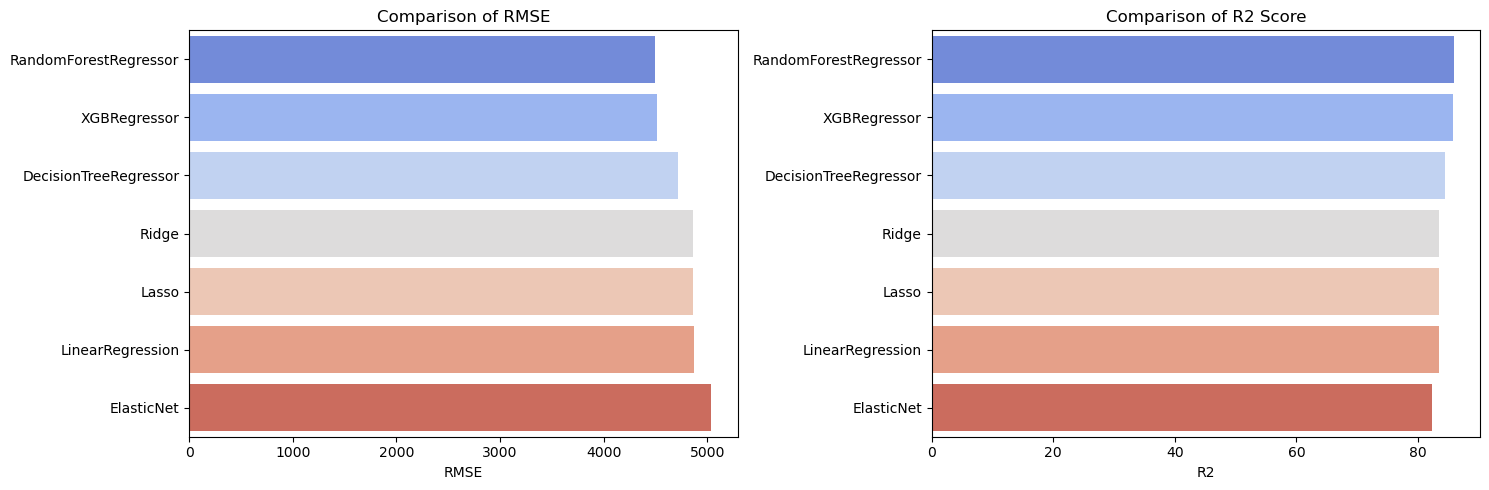

In [31]:
plot_model_comparison(results_grid_df)

### Feature Importance Visualization
We'll visualize the feature importance for the best models (Random Forest and XGBoost).

In [32]:
def plot_feature_importances(model):
    """
    Plot the feature importances of a machine learning model.

    Parameters:
    - model: The machine learning model for which the feature importances will be visualized.

    Returns:
    - None: This function generates and displays a feature importances plot for the given model.
    """
    model_name = type(model).__name__
    skplt.estimators.plot_feature_importances(model, feature_names=insurance_df.drop('charges', axis=1).columns,
                                            title=f'{model_name} feature importances')
    plt.xticks(rotation=0)

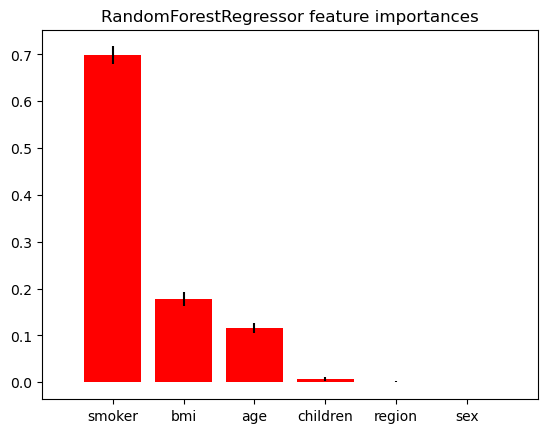

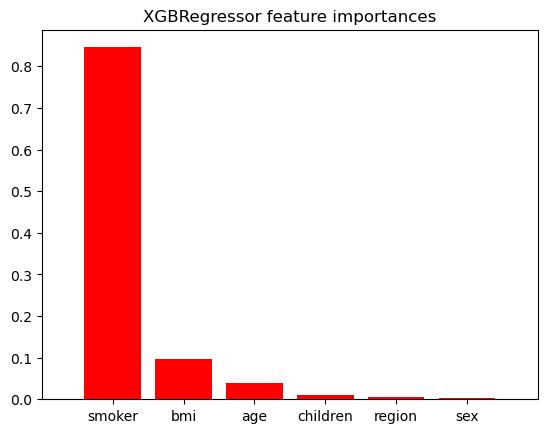

In [33]:
plot_feature_importances(rf_best_model)
plot_feature_importances(xgb_best_model)

### Decision Tree Visualization
We visualize one of the decision trees from the best-performing Random Forest model. This helps us understand how the model makes decisions.

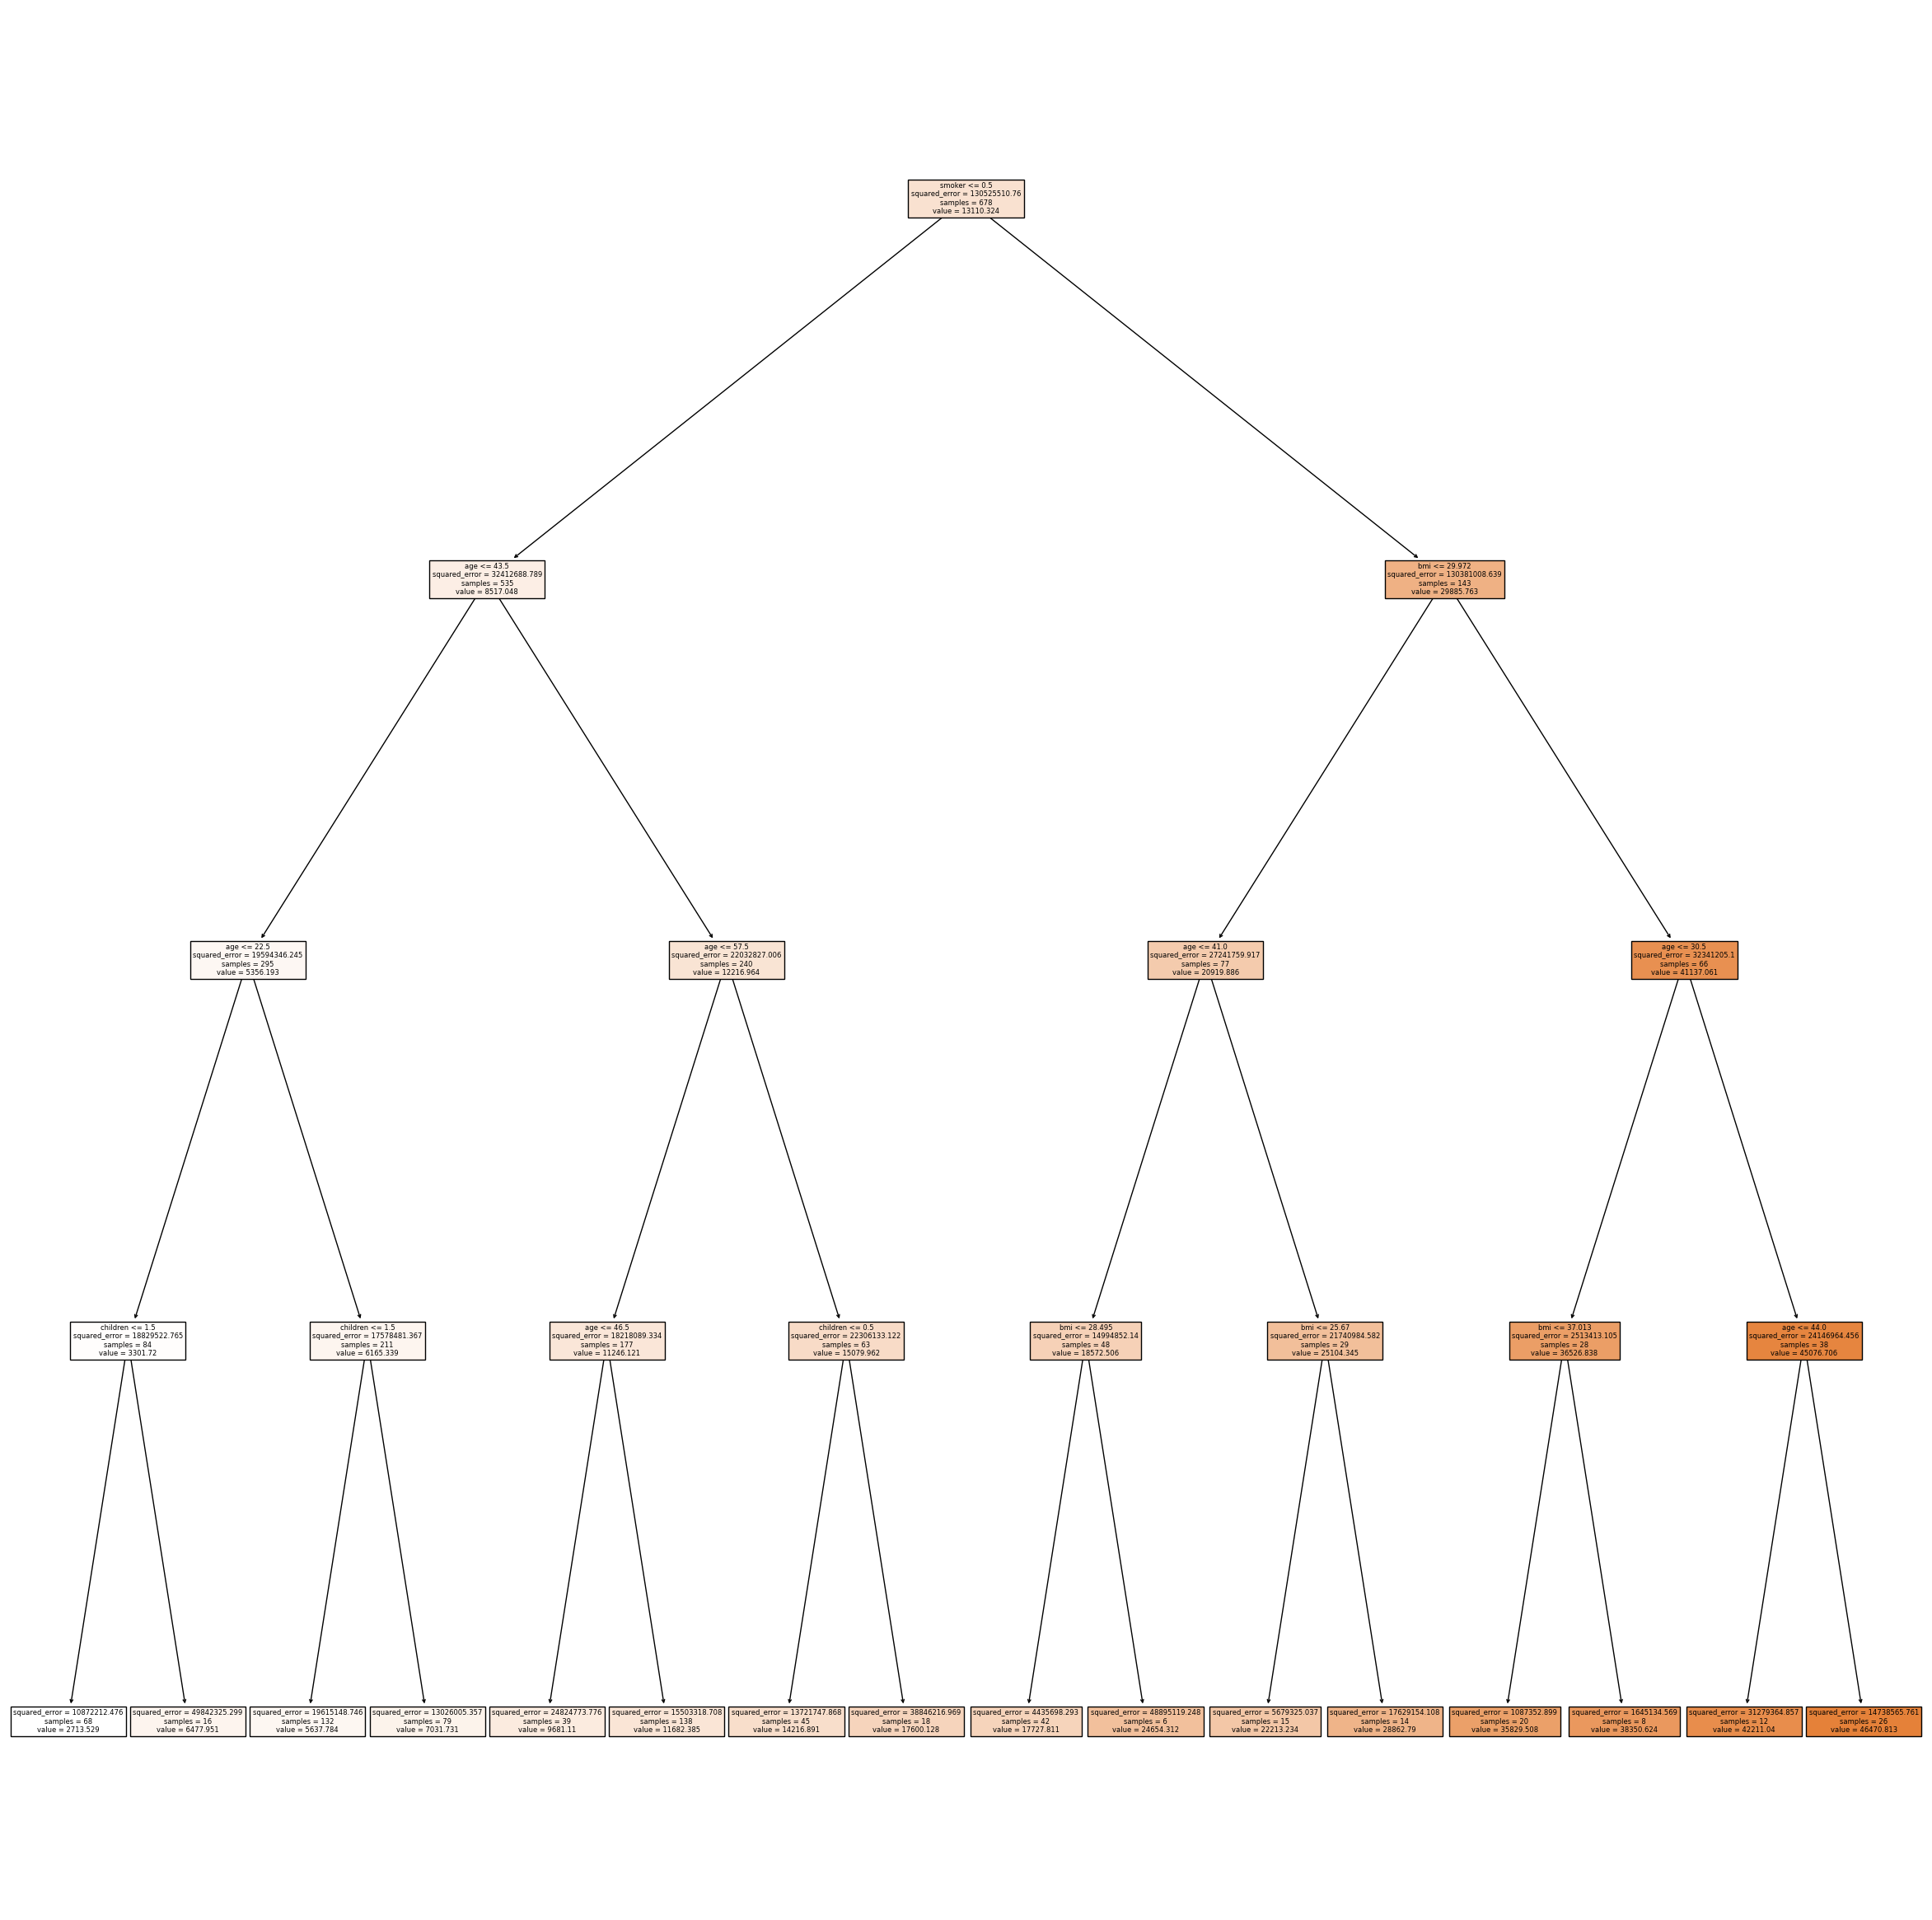

In [34]:
plt.figure(figsize = (30,30))
plot_tree(rf_best_model.estimators_[2],
          feature_names=rf_best_model.feature_names_in_,
          filled=True,)
plt.show()

Let's do the same for the XGBoost model.

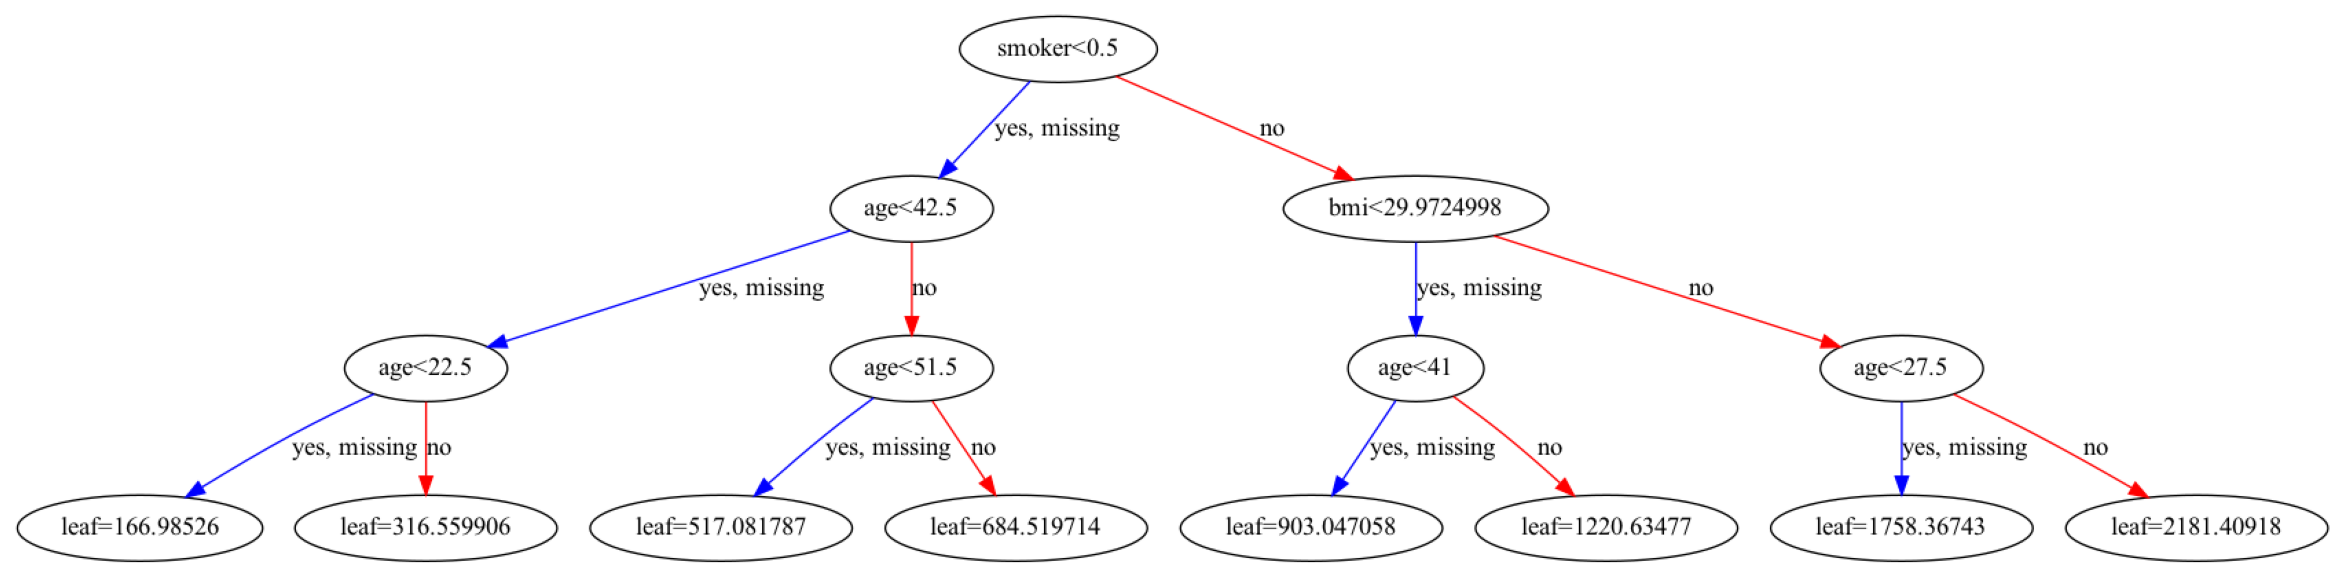

In [35]:
rcParams['figure.figsize'] = 30, 30
xgb.plot_tree(xgb_best_model)
plt.show()

### Sample Predictions
Let's make some sample predictions using the best estimator (Random Forest).

In [36]:
rf_best_model.fit(X_train, y_train)
y_test_pred = rf_best_model.predict(X_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
df.sample(10)

,Actual,Predicted
838,6402.29135,7690.756937
707,10264.44210,11082.686224
49,38709.17600,41717.456117
513,1256.29900,2835.071570
352,3554.20300,5119.905485
155,6948.70080,9533.683749
447,11454.02150,12868.501756
793,21195.81800,23670.152470
410,1621.34020,2808.711381
894,13555.00490,14177.526325


## Conclusion
In this analysis, we explored an insurance dataset and built predictive models to estimate medical insurance costs. We used various machine learning models and hyperparameter tuning technique to improve their performance. The Random Forest and XGBoost models showed the best performance for this task. Additionally, we examined the importance of different features in predicting insurance costs.